In [7]:
import pandas as pd
import numpy as np

df = pd.read_excel("items_with_orders.xlsx")  # 或 read_csv

# 建议重命名，方便写公式
df = df.rename(columns={
    "数据交易所": "platform",
    "映射为": "category",  # 如果这列确实是类别（10类），就这样命名
    "总条目数": "sku_total",
    "不同供应商数量": "supplier_n",
    "自供给条目数": "sku_self",
    "自供给占比": "self_share",
    "上线时间": "online_year",   # 如果是年份/月份也行
    "需求量": "orders"
})

df.head()


,platform,category,sku_total,sku_self,self_share,online_year,orders
0,丝路辉煌大数据交易中心,互联网/内容/媒体,8,0,0.000000,2014,0
1,丝路辉煌大数据交易中心,交通/出行,161,11,0.068323,2014,3
2,丝路辉煌大数据交易中心,位置/地图/时空,25,0,0.000000,2014,1
3,丝路辉煌大数据交易中心,其他（不可分类的）,51,4,0.078431,2014,5
4,丝路辉煌大数据交易中心,医疗/健康,9,0,0.000000,2014,3


In [8]:
# 去除 sku_total=0 的类别格子（否则 self_share 没意义）
df = df[df["sku_total"] > 0].copy()

# 如果 self_share 没算对，建议用 sku_self/sku_total 重新算
df["self_share"] = df["sku_self"] / df["sku_total"]

# 常用对数化
df["ln_orders"] = np.log(df["orders"] + 1)
df["ln_sku"] = np.log(df["sku_total"] + 1)

# 简单缩尾
def winsorize(s, p=0.01):
    lower, upper = s.quantile(p), s.quantile(1-p)
    return s.clip(lower, upper)

df["self_share_w"] = winsorize(df["self_share"], p=0.01)


In [9]:
# 假设 online_year 越小代表越早上线 => 越成熟
# 用中位数切分成熟期（最省样本）
median_year = df.groupby("platform")["online_year"].first().median()
platform_year = df.groupby("platform")["online_year"].first()

mature_map = (platform_year <= median_year).astype(int)  # 早上线 = mature=1
df["mature_time"] = df["platform"].map(mature_map)


In [10]:
cat_count = df.groupby("platform")["category"].nunique()
mature_map2 = (cat_count >= cat_count.median()).astype(int)
df["mature_catcount"] = df["platform"].map(mature_map2)

## 主回归

In [11]:
from linearmodels.panel import PanelOLS

# multi-index：平台是 entity，第二维给一个“伪时间”（numeric），但我们不用 time_effects
df2 = df.copy()

# 构造一个数值型伪时间（每个平台内按类别排序编号即可）
df2["t"] = df2.groupby("platform").cumcount()  # 0..9

df2 = df2.set_index(["platform", "t"])

y = df2["ln_orders"]
X = df2[["self_share_w", "ln_sku"]] #"ln_sku"

# 类别作为 other_effects（可以是字符串，也可以是分类变量）
other = df2[["category"]]  # DataFrame 形式

mod = PanelOLS(y, X, entity_effects=True, other_effects=other, drop_absorbed=True)
res = mod.fit(cov_type="clustered", cluster_entity=True)

print(res.summary)



                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_orders   R-squared:                        0.3866
Estimator:                   PanelOLS   R-squared (Between):              0.7108
No. Observations:                 241   R-squared (Within):               0.5619
Date:                Tue, Feb 24 2026   R-squared (Overall):              0.7023
Time:                        18:32:16   Log-likelihood                   -82.233
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      64.594
Entities:                          25   P-value                           0.0000
Avg Obs:                       9.6400   Distribution:                   F(2,205)
Min Obs:                       7.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             25.413
                            

## 初期促进、成熟抑制（交互项）

In [12]:
# 平台总SKU（跨类别加总）
platform_total_sku = df.groupby("platform")["sku_total"].sum()

# 用中位数切分成熟度（总SKU更大 = 更成熟）
median_total_sku = platform_total_sku.median()

mature_sku_map = (platform_total_sku >= median_total_sku).astype(int)

df["mature_sku"] = df["platform"].map(mature_sku_map)
df["mature_sku"].value_counts()

mature_sku
1    130
0    111
Name: count, dtype: int64

In [13]:
# 成熟组
df2 = df.copy()[df["mature_sku"] != 0]

# 构造一个数值型伪时间（每个平台内按类别排序编号即可）
df2["t"] = df2.groupby("platform").cumcount()  # 0..9

df2 = df2.set_index(["platform", "t"])

y = df2["ln_orders"]
X = df2[["self_share_w", "ln_sku"]] #"ln_sku"

# 类别作为 other_effects（可以是字符串，也可以是分类变量）
other = df2[["category"]]  # DataFrame 形式

mod = PanelOLS(y, X, entity_effects=True, other_effects=other, drop_absorbed=True)
res = mod.fit(cov_type="clustered", cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_orders   R-squared:                        0.4590
Estimator:                   PanelOLS   R-squared (Between):              0.7284
No. Observations:                 130   R-squared (Within):               0.6220
Date:                Tue, Feb 24 2026   R-squared (Overall):              0.7246
Time:                        18:32:16   Log-likelihood                   -13.508
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      44.968
Entities:                          13   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                   F(2,106)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             14.693
                            

In [14]:
# 不成熟组
df2 = df.copy()[df["mature_sku"] == 0]

# 构造一个数值型伪时间（每个平台内按类别排序编号即可）
df2["t"] = df2.groupby("platform").cumcount()  # 0..9

df2 = df2.set_index(["platform", "t"])

y = df2["ln_orders"]
X = df2[["self_share_w", "ln_sku"]] #"ln_sku"

# 类别作为 other_effects（可以是字符串，也可以是分类变量）
other = df2[["category"]]  # DataFrame 形式

mod = PanelOLS(y, X, entity_effects=True, other_effects=other, drop_absorbed=True)
res = mod.fit(cov_type="clustered", cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_orders   R-squared:                        0.3312
Estimator:                   PanelOLS   R-squared (Between):              0.7383
No. Observations:                 111   R-squared (Within):               0.4819
Date:                Tue, Feb 24 2026   R-squared (Overall):              0.7089
Time:                        18:32:17   Log-likelihood                   -50.614
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      21.785
Entities:                          12   P-value                           0.0000
Avg Obs:                       9.2500   Distribution:                    F(2,88)
Min Obs:                       7.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             12.120
                            

In [15]:
# 交互效应
from linearmodels.panel import PanelOLS

df2 = df.copy()
df2["t"] = df2.groupby("platform").cumcount()
df2 = df2.set_index(["platform", "t"])

y = df2["ln_orders"]

df2["self_x_mature_sku"] = df2["self_share_w"] * df2["mature_sku"]

X = df2[["self_share_w", "self_x_mature_sku", "ln_sku"]]

mod = PanelOLS(
    y, X,
    entity_effects=True,
    other_effects=df2[["category"]],
    drop_absorbed=True
)
res = mod.fit(cov_type="clustered", cluster_entity=True)
print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_orders   R-squared:                        0.3966
Estimator:                   PanelOLS   R-squared (Between):              0.7102
No. Observations:                 241   R-squared (Within):               0.5602
Date:                Tue, Feb 24 2026   R-squared (Overall):              0.7016
Time:                        18:32:17   Log-likelihood                   -80.248
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      44.693
Entities:                          25   P-value                           0.0000
Avg Obs:                       9.6400   Distribution:                   F(3,204)
Min Obs:                       7.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             20.826
                            

In [16]:
b1 = res.params["self_share_w"]              # 非成熟（mature_sku=0）
b2 = res.params["self_x_mature_sku"]         # 成熟平台的额外变化

print("初期/非成熟平台效应 =", b1)
print("成熟平台效应 =", b1 + b2)


初期/非成熟平台效应 = 0.9922649178744415
成熟平台效应 = -0.3444615356682873


## 稳健性分析

替换划分指标为成立时间

In [17]:
# 平台总SKU（跨类别加总）
platform_total_sku = df.groupby("platform")["online_year"].sum()

# 用中位数切分成熟度
median_total_sku = platform_total_sku.median()

mature_sku_map = (platform_total_sku >= median_total_sku).astype(int)

df["mature_sku"] = df["platform"].map(mature_sku_map)
df["mature_sku"].value_counts()

mature_sku
1    150
0     91
Name: count, dtype: int64

In [18]:
# 交互效应
from linearmodels.panel import PanelOLS

df2 = df.copy()
df2["t"] = df2.groupby("platform").cumcount()
df2 = df2.set_index(["platform", "t"])

y = df2["ln_orders"]

df2["self_x_mature_sku"] = df2["self_share_w"] * df2["mature_sku"]

X = df2[["self_share_w", "self_x_mature_sku", "ln_sku"]]

mod = PanelOLS(
    y, X,
    entity_effects=True,
    other_effects=df2[["category"]],
    drop_absorbed=True
)
res = mod.fit(cov_type="clustered", cluster_entity=True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_orders   R-squared:                        0.4066
Estimator:                   PanelOLS   R-squared (Between):              0.7102
No. Observations:                 241   R-squared (Within):               0.5673
Date:                Tue, Feb 24 2026   R-squared (Overall):              0.7019
Time:                        18:32:17   Log-likelihood                   -78.232
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      46.595
Entities:                          25   P-value                           0.0000
Avg Obs:                       9.6400   Distribution:                   F(3,204)
Min Obs:                       7.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             42.130
                            

## 连续指标

In [19]:
platform_total_sku = df.groupby("platform")["sku_total"].sum()

sku_min = platform_total_sku.min()
sku_max = platform_total_sku.max()

# 防止所有平台总SKU一样导致除以0
if sku_max == sku_min:
    mature_map = pd.Series(0.0, index=platform_total_sku.index)
else:
    mature_map = (platform_total_sku - sku_min) / (sku_max - sku_min)

df["mature_sku_mm"] = df["platform"].map(mature_map)

# （可选）看看分布
# print(df["mature_sku_mm"].describe())

# =========================
# 2) PanelOLS 回归（连续 mature + 交互项）
# =========================
df2 = df.copy()
df2["t"] = df2.groupby("platform").cumcount()
df2 = df2.set_index(["platform", "t"])

# 如果你的 ln_orders / ln_sku 还没生成，这里可以补上（按你原来的变量名）
# df2["ln_orders"] = np.log1p(df2["orders"])
# df2["ln_sku"] = np.log1p(df2["sku_total"])

y = df2["ln_orders"]

# 交互项：self_share_w × 连续成熟度
df2["self_x_mature_mm"] = df2["self_share_w"] * df2["mature_sku_mm"]

X = df2[["self_share_w", "self_x_mature_mm", "ln_sku"]]

mod = PanelOLS(
    y, X,
    entity_effects=True,
    other_effects=df2[["category"]],
    drop_absorbed=True
)

res = mod.fit(cov_type="clustered", cluster_entity=True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_orders   R-squared:                        0.3985
Estimator:                   PanelOLS   R-squared (Between):              0.7121
No. Observations:                 241   R-squared (Within):               0.5645
Date:                Tue, Feb 24 2026   R-squared (Overall):              0.7036
Time:                        18:32:17   Log-likelihood                   -79.862
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      45.055
Entities:                          25   P-value                           0.0000
Avg Obs:                       9.6400   Distribution:                   F(3,204)
Min Obs:                       7.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             19.598
                            

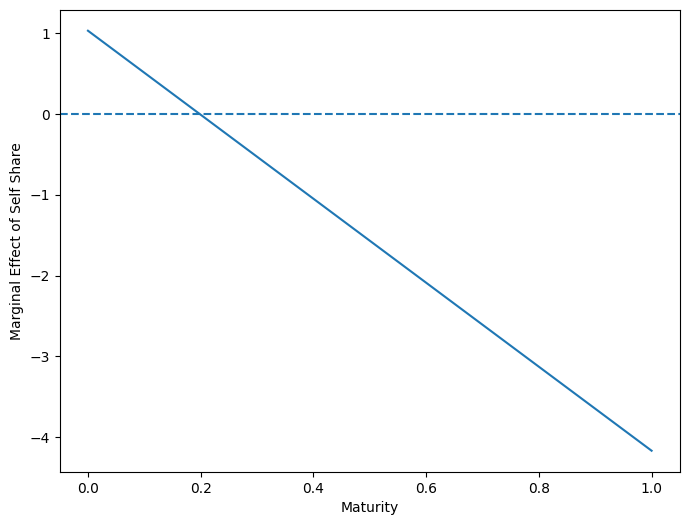

In [20]:
import numpy as np
import matplotlib.pyplot as plt

b1 = 1.0266
b3 = -5.1923

M_range = np.linspace(0,1,100)
ME = b1 + b3*M_range

plt.figure(figsize=(8,6))
plt.plot(M_range, ME)
plt.axhline(0, linestyle="--")
plt.xlabel("Maturity")
plt.ylabel("Marginal Effect of Self Share")
plt.show()
